# Clustering jerárquico divisivo

Este conjunto de datos contiene información de perfiles de usuarios de redes sociales, recolectada con fines de análisis o clasificación. Cada fila representa un usuario individual, e incluye tanto metadatos del perfil como atributos relacionados con su actividad y posibles indicadores de comportamiento.

| Campo          | Descripción                                                                 | Tipo de dato        |
| -------------- | --------------------------------------------------------------------------- | ------------------- |
| `id`           | Identificador único del usuario.                                            | Numérico            |
| `name`         | Nombre o alias público del usuario.                                         | Texto               |
| `ranking`      | Clasificación numérica del usuario según un criterio definido.              | Numérico            |
| `red`          | Código de la red social (p. ej., 1 = Twitter).                              | Categórico          |
| `followers`    | Número de seguidores que tiene el usuario.                                  | Numérico            |
| `extract_date` | Fecha y hora en que se extrajo el perfil.                                   | Fecha/Hora          |
| `username`     | Nombre de usuario (handle).                                                 | Texto               |
| `usage`        | Nivel o tipo de uso del perfil (definición específica depende del sistema). | Categórico          |
| `description`  | Descripción del perfil proporcionada por el usuario.                        | Texto               |
| `professions`  | Profesiones asociadas al usuario.                                           | Texto (opcional)    |
| `preferences`  | Intereses o preferencias del usuario.                                       | Texto/Categórico    |
| `age`          | Edad del usuario.                                                           | Numérico            |
| `location`     | Ubicación geográfica del usuario.                                           | Texto (opcional)    |
| `gen`          | Género del usuario (p. ej., M = Masculino, F = Femenino).                   | Categórico          |
| `org`          | Si pertenece a una organización (Y = sí, N = no).                           | Booleano/Categórico |
| `created_at`   | Fecha de creación de la cuenta.                                             | Fecha/Hora          |
| `pic`          | URL de la imagen de perfil del usuario.                                     | Texto (URL)         |
| `posts`        | Número de publicaciones realizadas por el usuario.                          | Numérico            |
| `lang`         | Idioma principal del perfil.                                                | Categórico          |
| `country`      | País de origen o ubicación del perfil.                                      | Categórico          |
| `bot_score`    | Puntaje de probabilidad de ser bot (0 = humano, mayor = más probable).      | Numérico            |
| `friends`      | Número de cuentas que sigue el usuario.                                     | Numérico            |


Estos datos se van a transformar para obtener nuevas variables derivadas de los mismos como se muestra a continuación:

| Campo                       | Descripción                                                                                 | Tipo de dato   |
| --------------------------- | ------------------------------------------------------------------------------------------- | -------------- |
| `total_chars_name`          | Número total de caracteres en el campo `name`.                                              | Numérico       |
| `total_chars_description`   | Número total de caracteres en la `description`.                                             | Numérico       |
| `total_chars_username`      | Número total de caracteres en el `username`.                                                | Numérico       |
| `name_equals_username`      | Indicador binario que vale 1 si `name` es igual a `username`, 0 en caso contrario.          | Booleano (0/1) |
| `total_numbers_name`        | Número total de caracteres numéricos en el `name`.                                          | Numérico       |
| `total_numbers_username`    | Número total de caracteres numéricos en el `username`.                                      | Numérico       |
| `total_emojis_name`         | Número total de emojis presentes en el `name`.                                              | Numérico       |
| `total_emojis_username`     | Número total de emojis presentes en el `username`.                                          | Numérico       |
| `total_words_description`   | Número total de palabras en el campo `description`.                                         | Numérico       |
| `total_emojis_description`  | Número total de emojis presentes en el campo `description`.                                 | Numérico       |
| `total_numbers_description` | Número total de caracteres numéricos en la `description`.                                   | Numérico       |
| `total_words_name`          | Número total de palabras en el `name`.                                                      | Numérico       |
| `followers`                 | Número de seguidores del usuario (copia directa del campo original).                        | Numérico       |
| `friends`                   | Número de cuentas que sigue el usuario (copia directa del campo original).                  | Numérico       |
| `age`                       | Edad del usuario (copia directa del campo original).                                        | Numérico       |
| `gen`                       | Género del usuario, transformado a una representación estandarizada (por ejemplo, 'M'/'F'). | Categórico     |
| `org`                       | Si el perfil es de una organización, estandarizado como booleano (1 = sí, 0 = no).          | Booleano (0/1) |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from scripts.linkage import LinkageWrapper
from scripts.dataframe_manager import ArrayToDFTransformer
from sklearn.pipeline import Pipeline
from scripts.divisive import divisive_clustering

In [2]:
df = pd.read_csv('../datasets/profiles/profiles_features.csv', header=0)

Exploración de datos

In [3]:
print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
   total_chars_name  total_chars_description  total_chars_username  \
0              42.0                      8.0                  10.0   
1              24.0                      0.0                  13.0   
2              15.0                     30.0                  14.0   
3               1.0                      0.0                  13.0   
4              26.0                      1.0                  17.0   

   name_equals_username  total_numbers_name  total_numbers_username  \
0                   0.0                 0.0                     4.0   
1                   0.0                 0.0                     0.0   
2                   0.0                 0.0                     0.0   
3                   0.0                 0.0                     2.0   
4                   0.0                 0.0                     0.0   

   total_emojis_name  total_emojis_username  total_words_description  \
0                3.0                    0.0         

In [4]:
print("\nResumen estadístico:")
print(df.describe())


Resumen estadístico:
       total_chars_name  total_chars_description  total_chars_username  \
count      10000.000000              10000.00000          10000.000000   
mean          12.817100                 47.35640             12.047300   
std            7.539823                 52.17223              3.390724   
min            0.000000                  0.00000              3.000000   
25%            8.000000                  0.00000             10.000000   
50%           12.000000                 26.00000             12.000000   
75%           16.000000                 88.00000             14.000000   
max           63.000000                174.00000             30.000000   

       name_equals_username  total_numbers_name  total_numbers_username  \
count          10000.000000        10000.000000            10000.000000   
mean               0.022100            0.134500                1.468200   
std                0.147016            0.735706                2.255238   
min        

In [5]:
print("\nValores nulos:")
print(df.isnull().sum())


Valores nulos:
total_chars_name               0
total_chars_description        0
total_chars_username           0
name_equals_username           0
total_numbers_name             0
total_numbers_username         0
total_emojis_name              0
total_emojis_username          0
total_words_description        0
total_emojis_description       0
total_numbers_description      0
total_words_name               0
followers                     18
friends                       25
age                          409
gen                          409
org                          410
dtype: int64


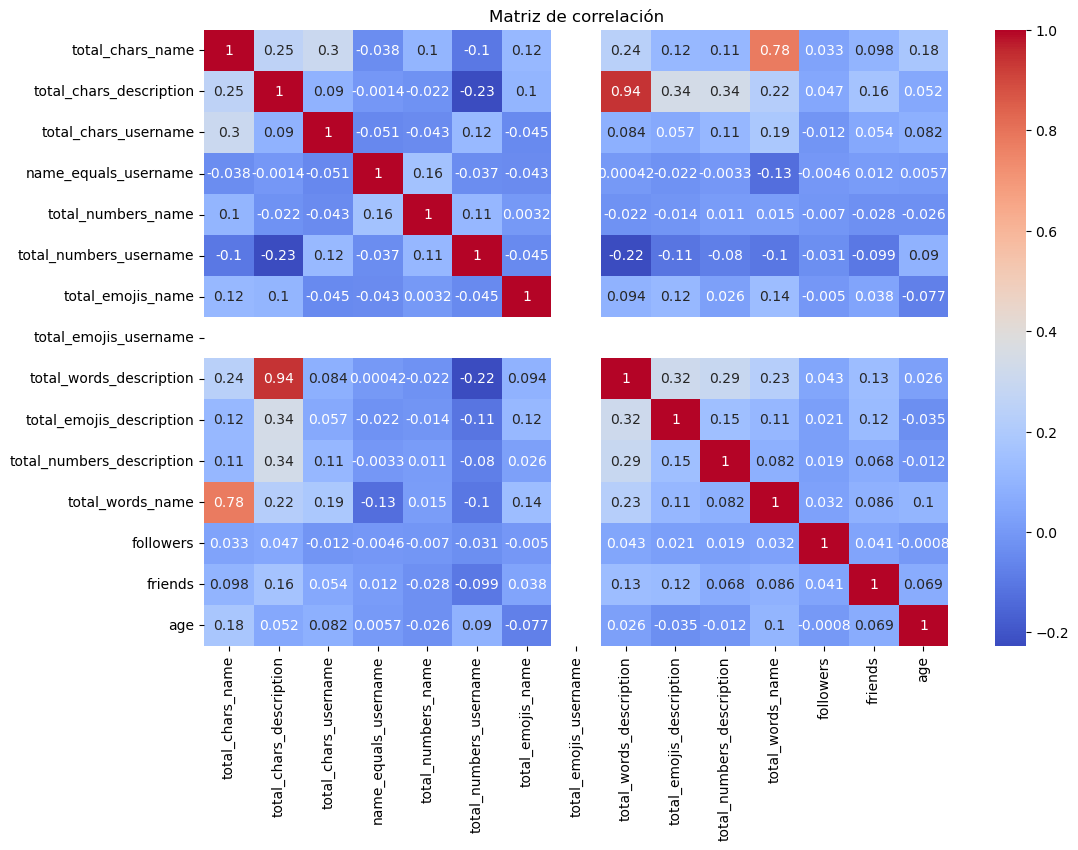

In [6]:
# Correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

Limpieza y tratamiento de datos

In [7]:
print(df.isnull().sum())

total_chars_name               0
total_chars_description        0
total_chars_username           0
name_equals_username           0
total_numbers_name             0
total_numbers_username         0
total_emojis_name              0
total_emojis_username          0
total_words_description        0
total_emojis_description       0
total_numbers_description      0
total_words_name               0
followers                     18
friends                       25
age                          409
gen                          409
org                          410
dtype: int64


Selección de variables

In [8]:
df.columns

Index(['total_chars_name', 'total_chars_description', 'total_chars_username',
       'name_equals_username', 'total_numbers_name', 'total_numbers_username',
       'total_emojis_name', 'total_emojis_username', 'total_words_description',
       'total_emojis_description', 'total_numbers_description',
       'total_words_name', 'followers', 'friends', 'age', 'gen', 'org'],
      dtype='object')

In [9]:
features = ['total_chars_name', 'total_chars_description', 'total_chars_username',
       'name_equals_username', 'total_numbers_name', 'total_numbers_username',
       'total_emojis_name', 'total_emojis_username', 'total_words_description',
       'total_emojis_description', 'total_numbers_description',
       'total_words_name', 'followers', 'friends', 'age', 'gen', 'org']

In [10]:
# Seleccionar columnas categóricas y numéricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nColumnas categóricas:", categorical_cols)
print("Columnas numéricas: ", numerical_cols)


Columnas categóricas: ['gen', 'org']
Columnas numéricas:  ['total_chars_name', 'total_chars_description', 'total_chars_username', 'name_equals_username', 'total_numbers_name', 'total_numbers_username', 'total_emojis_name', 'total_emojis_username', 'total_words_description', 'total_emojis_description', 'total_numbers_description', 'total_words_name', 'followers', 'friends', 'age']


In [11]:
categorical_cols.append('age')
numerical_cols.remove('age')
print("\nColumnas categóricas:", categorical_cols)
print("Columnas numéricas: ", numerical_cols)


Columnas categóricas: ['gen', 'org', 'age']
Columnas numéricas:  ['total_chars_name', 'total_chars_description', 'total_chars_username', 'name_equals_username', 'total_numbers_name', 'total_numbers_username', 'total_emojis_name', 'total_emojis_username', 'total_words_description', 'total_emojis_description', 'total_numbers_description', 'total_words_name', 'followers', 'friends']


In [12]:
preprocessor_imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols),
    ],
    remainder='passthrough'
    )

preprocessor_encoder = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols)   
    ],
    remainder='passthrough'
    )

# Opcional: Agregar codificación si lo deseas después de la imputación
full_pipeline = Pipeline([
    ('imputer', preprocessor_imputer),
    ('to_df_1', ArrayToDFTransformer(features)),
    ('encoder', preprocessor_encoder),
    ('to_df_2', ArrayToDFTransformer(features)),
    ('print', 'passthrough'),
])

In [13]:
X = df[features]

In [14]:
X

,total_chars_name,total_chars_description,total_chars_username,name_equals_username,total_numbers_name,total_numbers_username,total_emojis_name,total_emojis_username,total_words_description,total_emojis_description,total_numbers_description,total_words_name,followers,friends,age,gen,org
0,42.0,8.0,10.0,0.0,0.0,4.0,3.0,0.0,1.0,0.0,1.0,7.0,195.0,463.0,3.0,M,N
1,24.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,2.0,M,N
2,15.0,30.0,14.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,71.0,2.0,M,N
3,1.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,88.0,0.0,M,N
4,26.0,1.0,17.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,30.0,330.0,0.0,F,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,14.0,42.0,9.0,0.0,0.0,1.0,0.0,0.0,8.0,5.0,12.0,2.0,14782.0,1514.0,NaN,NaN,NaN
9996,39.0,91.0,12.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,5.0,689.0,4247.0,1.0,M,N
9997,13.0,15.0,13.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,39.0,0.0,M,N
9998,12.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,271.0,1.0,F,N


Modelo

In [15]:
full_pipeline.fit(X)

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', SimpleImputer(),
                                                  ['total_chars_name',
                                                   'total_chars_description',
                                                   'total_chars_username',
                                                   'name_equals_username',
                                                   'total_numbers_name',
                                                   'total_numbers_username',
                                                   'total_emojis_name',
                                                   'total_emojis_username',
                                                   'total_words_description',
                                                   'total_emojis_description',
                                                   'total_nu...
                                                   'total_numbers_name',
                                                   'total_numbers_username',
                                                   'total_emojis_name',
                                                   'total_emojis_username',
                                                   'total_words_description',
                                                   'total_emojis_description',
                                                   'total_numbers_description',
                                                   'total_words_name',
                                                   'followers', 'friends']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['gen', 'org', 'age'])])),
                ('to_df_2',
                 <scripts.dataframe_manager.ArrayToDFTransformer object at 0x79638da2e020>),
                ('print', 'passthrough')])

In [16]:
n_clusters = 3
from scripts.divisive import divisive_clustering


In [17]:
df['cluster'] = divisive_clustering(full_pipeline.named_steps['to_df_2'].get_dataframe(), max_clusters=n_clusters)

Divisive clustering with max_clusters=3


In [18]:
df['cluster']

0       0
1       1
2       1
3       2
4       2
       ..
9995    0
9996    0
9997    2
9998    2
9999    2
Name: cluster, Length: 10000, dtype: int64

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(full_pipeline.named_steps['to_df_2'].get_dataframe())

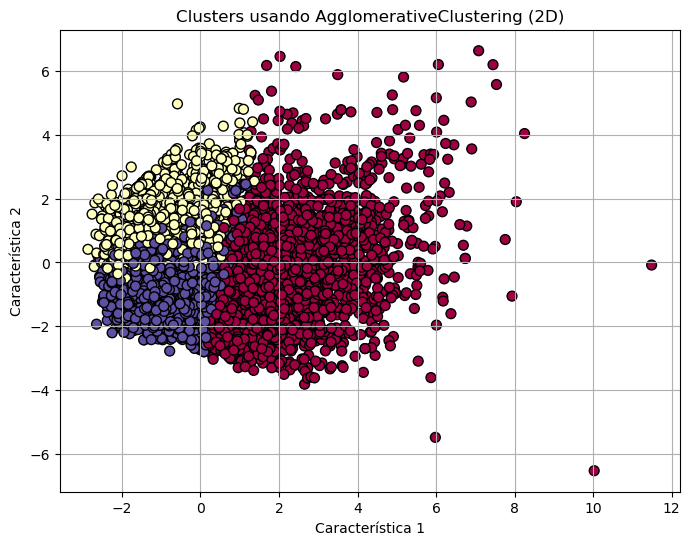

In [20]:
x = X_pca[:, 0]
y = X_pca[:, 1]
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=df['cluster'], cmap='Spectral', s=50, edgecolor='k')
plt.title("Clusters usando AgglomerativeClustering (2D)")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.grid(True)
plt.show()

In [21]:
# === 6. Evaluación del modelo ===
sil_score = silhouette_score(full_pipeline.named_steps['to_df_2'].get_dataframe(), df['cluster'])
print(f"Silhouette Score para {n_clusters} clusters: {sil_score:.4f}")

Silhouette Score para 3 clusters: 0.1085


Evaluación

In [22]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(full_pipeline.named_steps['to_df_2'].get_dataframe())

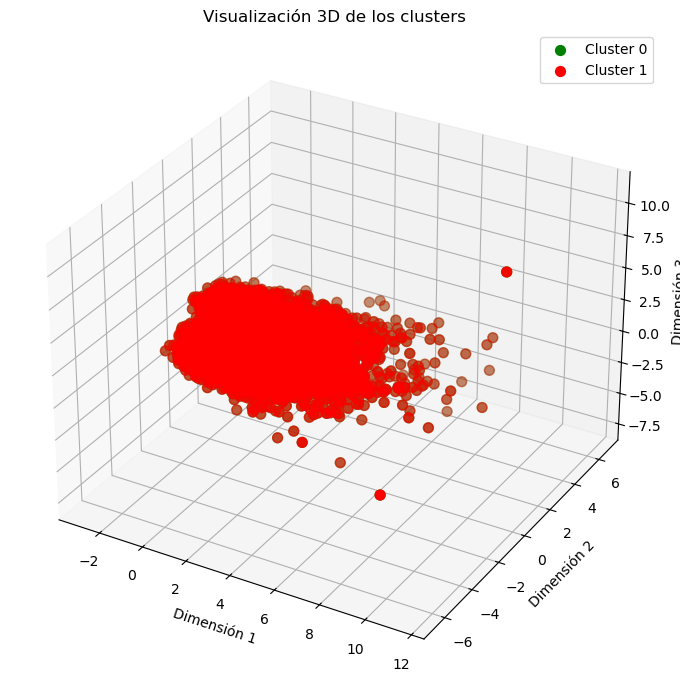

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necesario para gráficos 3D
labels = [df['cluster'].values]
x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

# Crear figura y eje 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Colores por cluster
colors = ['g', 'r']

# Graficar cada punto
for color, i in zip(colors, np.unique(labels)):
    ax.scatter(x,y,z, s=50, c=[color], label=f'Cluster {i}')

# Configuraciones
ax.set_title('Visualización 3D de los clusters')
ax.set_xlabel('Dimensión 1')
ax.set_ylabel('Dimensión 2')
ax.set_zlabel('Dimensión 3')
ax.legend()

plt.tight_layout()
plt.show()

<Axes: xlabel='cluster'>

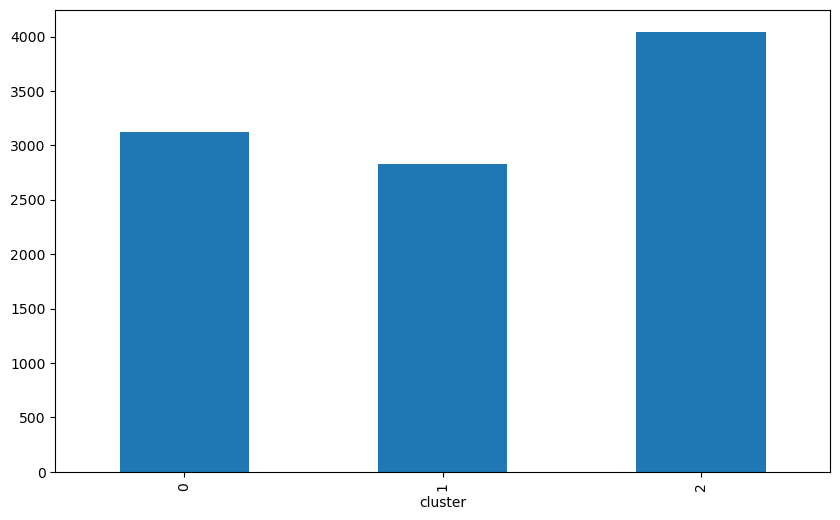

In [24]:
df.cluster.value_counts().sort_index().plot(kind='bar', figsize=(10, 6))